In [1]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(10, 8)
plt.style.use(['dark_background'])

In [3]:
import pickle

corpus_text = pickle.load(
    open("corpus_text.pickle", "rb")
)

In [4]:
word2id, id2word = {}, {}

uniques = set()
for words in corpus_text:
    for w in words:
        uniques.add(w)

count_id = 0
for word in uniques:
    word2id[word] = count_id
    id2word[count_id] = word
    count_id += 1

In [5]:
id2word[23]

'bem'

In [6]:
len(uniques), len(corpus_text)

(618, 61)

In [7]:
window = 2
pair_ids = []

text_size = len(corpus_text)

corpus_text = np.array(corpus_text)
mask = np.array([i for i in range(-window, window+1) if i is not 0])

for paragraph in corpus_text:
    paragraph = np.array(paragraph)
    text_size = len(paragraph)

    for center_word in range(window, text_size-window):
        center_word_id = word2id[paragraph[center_word]]
        context_words = [word2id[i] for i in paragraph[mask + center_word]]

        pair_ids.append([context_words, center_word_id])

In [8]:
from IPython.display import Markdown

In [9]:
ex_out = "|contexto | central | contexto | central |\n|--|--|--|--|\n"
for i in range(95, 106):
    w0, w1 = pair_ids[i]
    ex_out += f"|{w0} | {w1} | {[id2word[w] for w in w0]} | {id2word[w1]}|\n"

Markdown(ex_out)

|contexto | central | contexto | central |
|--|--|--|--|
|[282, 334, 610, 418] | 151 | ['sobre', 'base', 'morfogênese', 'previu'] | química|
|[334, 151, 418, 235] | 610 | ['base', 'química', 'previu', 'reações'] | morfogênese|
|[151, 610, 235, 441] | 418 | ['química', 'morfogênese', 'reações', 'químicas'] | previu|
|[610, 418, 441, 325] | 235 | ['morfogênese', 'previu', 'químicas', 'oscilantes'] | reações|
|[418, 235, 325, 350] | 441 | ['previu', 'reações', 'oscilantes', 'reação'] | químicas|
|[235, 441, 350, 47] | 325 | ['reações', 'químicas', 'reação', 'belousov'] | oscilantes|
|[441, 325, 47, 251] | 350 | ['químicas', 'oscilantes', 'belousov', 'zhabotinsky'] | reação|
|[325, 350, 251, 275] | 47 | ['oscilantes', 'reação', 'zhabotinsky', 'observadas'] | belousov|
|[350, 47, 275, 348] | 251 | ['reação', 'belousov', 'observadas', 'primeira'] | zhabotinsky|
|[47, 251, 348, 80] | 275 | ['belousov', 'zhabotinsky', 'primeira', 'vez'] | observadas|
|[251, 275, 80, 356] | 348 | ['zhabotinsky', 'observadas', 'vez', 'década'] | primeira|


In [10]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, emb_size, context_size):
        super(CBOW, self).__init__()
        
        self.embeddings = torch.nn.Embedding(vocab_size, emb_size)
        
        self.linear0 =  torch.nn.Linear(2*emb_size*context_size, 512)
        self.linear1 = torch.nn.Linear(512, vocab_size)

        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.embeddings(x).view(1, -1)

        out = self.linear0(out)
        out = self.linear1(out)
        
        out = self.log_softmax(out)
        return out
    
    def get_word_emb(self, word_id):
        word = torch.LongTensor([word_id])
        return self.embeddings(word).view(1, -1)

In [11]:
cbow = CBOW(len(uniques), 10, 2)

In [12]:
teste_data = torch.LongTensor(pair_ids[100][0])
target_data = torch.LongTensor(pair_ids[100][1])
res = cbow(teste_data).argmax().item()
id2word[res]

'estrogênio'

In [13]:
nll_loss = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=0.001)

indexes = np.arange(len(pair_ids))
losses = []
for epoch in range(201):
    np.random.shuffle(indexes)
    for index in indexes:
        context, target = pair_ids[index]
        optimizer.zero_grad()
        cbow.zero_grad()
        
        X = torch.LongTensor(context)
        Y = torch.LongTensor([target])
        out_prob = cbow(X)
        loss = nll_loss(out_prob, Y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    if epoch %20 == 0:
        print(f"{epoch:<2} - {loss.item():.3f}")

0  - 6.357
20 - 2.174
40 - 0.297
60 - 0.219
80 - 0.156
100 - 0.031
120 - 0.057
140 - 0.037
160 - 0.063
180 - 0.020
200 - 0.011


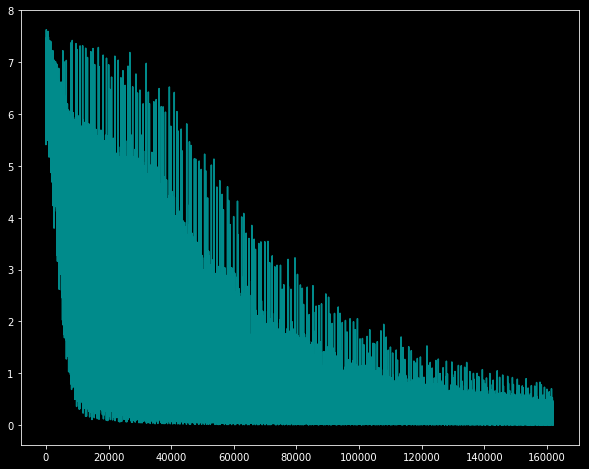

In [50]:
fig = figure()
ax = fig.gca()
ax.plot(losses, c="darkcyan")
savefig("../images/word2vec-cbow-loss.png", dpi="figure", transparent=True)

In [15]:
_pos = 28
teste_data = torch.LongTensor(pair_ids[_pos][0])
target_data = torch.LongTensor(pair_ids[_pos][1])
res = cbow(teste_data).argmax().item()
print(f"data:{[id2word[i] for i in pair_ids[_pos][0]]} | target: {id2word[pair_ids[_pos][1]]}")
print(f"{id2word[res]}")


data:['papel', 'importante', 'computador', 'moderno'] | target: criação
criação


In [16]:
cbow.get_word_emb(_pos).detach().numpy()

array([[ 0.04994071,  1.0177861 ,  1.45093   , -0.19134155, -0.6032207 ,
         1.9121735 , -1.211824  , -2.03557   ,  1.1069264 ,  0.06765856]],
      dtype=float32)

In [17]:
from sklearn.decomposition import PCA
import pandas as pd

In [18]:
dataf = pd.DataFrame({
    "words":list(uniques),
    "id": [word2id[i] for i in uniques],
    "emb": [cbow.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques],
    "x" : [0]*len(uniques),
    "y": [0]*len(uniques)
})

In [19]:
dataf.head()

,words,id,emb,x,y
0,pedirem,0,"[-0.7472434, 1.1953129, 0.6171143, 1.159434, 0...",0,0
1,apesar,1,"[1.4737017, -2.0915306, -0.7725572, -0.9709654...",0,0
2,matado,2,"[0.41868037, -1.2745695, 0.4692667, 0.8028619,...",0,0
3,books,3,"[-0.5160581, -1.2895256, -1.379968, -1.163356,...",0,0
4,argumentou,4,"[0.7462581, 0.4990972, -1.4993006, -0.06217622...",0,0


In [20]:
pca = PCA(n_components=2)
a = np.array([cbow.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques],)
XY = pca.fit_transform(a)

In [21]:
dataf["x"] = XY[:, 0]
dataf["y"] = XY[:, 1]
dataf.head()

,words,id,emb,x,y
0,pedirem,0,"[-0.7472434, 1.1953129, 0.6171143, 1.159434, 0...",-1.913741,0.762647
1,apesar,1,"[1.4737017, -2.0915306, -0.7725572, -0.9709654...",1.505951,-1.844195
2,matado,2,"[0.41868037, -1.2745695, 0.4692667, 0.8028619,...",0.579081,0.473435
3,books,3,"[-0.5160581, -1.2895256, -1.379968, -1.163356,...",1.531998,0.597777
4,argumentou,4,"[0.7462581, 0.4990972, -1.4993006, -0.06217622...",1.537176,0.908637


In [22]:
import altair as alt

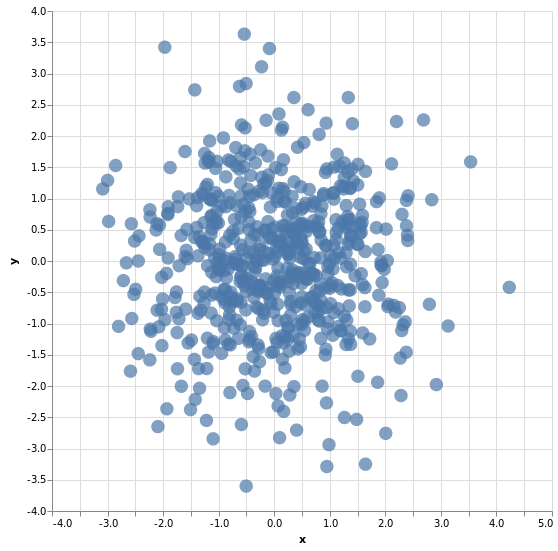

In [23]:
alt.themes.enable('opaque')
base = alt.Chart(dataf).properties(
        width=500,
        height=500
    )

base.mark_circle(size=180).encode(x="x", y="y", tooltip="words")

In [24]:
from knn_eucl_cos import knn

In [40]:
w = word2id["guerra"]

matrix = np.array([cbow.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques])
result_pos, result_values = knn(dataf.emb, pos=w, n=10)
result_p_eucl, result_v_eucl = knn(dataf.emb, pos=w, n=10, func="eucl")

mark = "| rank sim cos| - | rank dist eucl | - |\n|--|--|--|--|\n"
for i, j, k, l in zip(result_pos, result_values, result_p_eucl, result_v_eucl):
    mark += f"|{id2word[i]:<13} | {j:.5f} | {id2word[k]:<13} | {l:.5f}|\n"

Markdown(mark)

| rank sim cos| - | rank dist eucl | - |
|--|--|--|--|
|novas         | 0.28059 | novas         | 0.09326|
|equivalia     | 0.31309 | polonesa      | 0.09989|
|pioneiro      | 0.31798 | neve          | 0.10029|
|afirma        | 0.32445 | andrew        | 0.10191|
|neve          | 0.33447 | pioneiro      | 0.10310|
|polonesa      | 0.33585 | afirma        | 0.10484|
|massachusetts | 0.34675 | conduzida     | 0.10508|
|conduzida     | 0.34768 | bombas        | 0.10641|
|andrew        | 0.35143 | manipular     | 0.10718|
|hastings      | 0.35665 | homossexuais  | 0.11074|


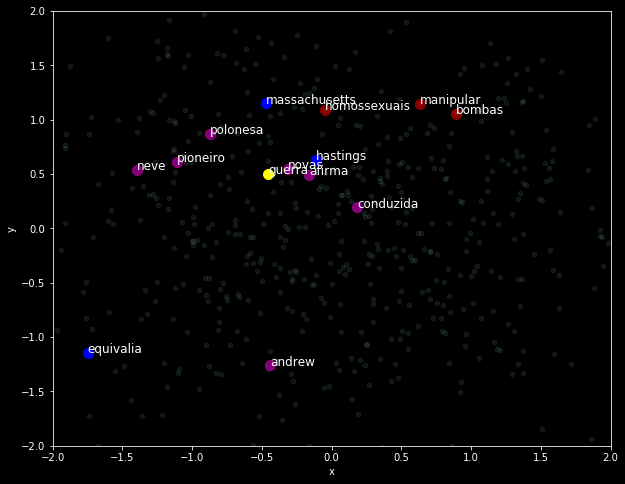

In [101]:
fig = figure()
ax = fig.gca()
dataf.plot.scatter("x", "y", ax=ax, alpha=0.1)
dataf.query(f"id == {w}").plot.scatter("x", "y", ax=ax, s=100, c="yellow")
dataf[dataf['id'].isin(result_pos)].plot.scatter("x", "y", ax=ax, s=100, c="blue")
dataf[dataf['id'].isin(result_p_eucl)].plot.scatter("x", "y", ax=ax, s=100, c="red", alpha=0.5)

for i in set(result_p_eucl.tolist() + result_pos.tolist() + [w]):
    coord = dataf.query(f"id=={i}")
    ax.annotate(coord.words.values[0],(coord.x,coord.y), size=12)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
savefig("../images/word2vec-cbow-rank.png", dpi="figure", transparent=True)